# Image Prediction - Quick Start

This notebook is implementation of [the link](https://auto.gluon.ai/stable/tutorials/image_prediction/beginner.html#image-prediction-quick-start)

In [1]:
%load_ext lab_black

In [2]:
import autogluon.core as ag
from autogluon.vision import ImagePredictor, ImageDataset

/Users/traveroliver/Library/Caches/pypoetry/virtualenvs/autoguluon-sandbox-uyisuGyl-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
train_dataset, _, test_dataset = ImageDataset.from_folders(
    "https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip"
)
print(train_dataset)

data/
├── .DS_Store
├── test/
└── train/
                                                 image  label
0    /Users/traveroliver/.gluoncv/datasets/shopee-i...      0
1    /Users/traveroliver/.gluoncv/datasets/shopee-i...      0
2    /Users/traveroliver/.gluoncv/datasets/shopee-i...      0
3    /Users/traveroliver/.gluoncv/datasets/shopee-i...      0
4    /Users/traveroliver/.gluoncv/datasets/shopee-i...      0
..                                                 ...    ...
795  /Users/traveroliver/.gluoncv/datasets/shopee-i...      3
796  /Users/traveroliver/.gluoncv/datasets/shopee-i...      3
797  /Users/traveroliver/.gluoncv/datasets/shopee-i...      3
798  /Users/traveroliver/.gluoncv/datasets/shopee-i...      3
799  /Users/traveroliver/.gluoncv/datasets/shopee-i...      3

[800 rows x 2 columns]


In [5]:
predictor = ImagePredictor()
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(
    train_dataset, hyperparameters={"epochs": 2}
)  # you can trust the default config, we reduce the # epoch to save some build time

`time_limit=auto` set to `time_limit=7200`.
Reset labels to [0, 1, 2, 3]
Randomly split train_data into train[720]/validation[80] splits.
No GPU detected/allowed, using most conservative search space.
Starting fit without HPO
modified configs(<old> != <new>): {
root.gpus            (0,) != ()
root.misc.num_workers 4 != 8
root.misc.seed       42 != 766
root.train.early_stop_max_value 1.0 != inf
root.train.epochs    200 != 2
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.img_cls.model   resnet101 != resnet18
}
Saved config to /Users/traveroliver/workspace/autoguluon-sandbox/notebooks/5ae8a2a4/.trial_0/config.yaml
Model resnet18 created, param count:                                         11178564
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
[Epoch 0] training: accuracy=0.304167
[Epoch 0] speed: 6 samples/sec	time cost: 107.403479
[Epoch 0] validation

In [6]:
fit_result = predictor.fit_summary()
print(
    "Top-1 train acc: %.3f, val acc: %.3f"
    % (fit_result["train_acc"], fit_result["valid_acc"])
)

Top-1 train acc: 0.657, val acc: 0.850


In [7]:
image_path = test_dataset.iloc[0]["image"]
result = predictor.predict(image_path)
print(result)

0    1
Name: label, dtype: int64


In [8]:
proba = predictor.predict_proba(image_path)
print(proba)

          0         1         2         3
0  0.084013  0.906092  0.001293  0.008601


In [9]:
bulk_result = predictor.predict(test_dataset)
print(bulk_result)

0     1
1     1
2     1
3     2
4     0
     ..
75    3
76    3
77    3
78    3
79    3
Name: label, Length: 80, dtype: int64


In [10]:
image_path = test_dataset.iloc[0]["image"]
feature = predictor.predict_feature(image_path)
print(feature)

                                       image_feature  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               image  
0  /Users/traveroliver/.gluoncv/datasets/shopee-i...  


In [11]:
test_acc = predictor.evaluate(test_dataset)
print("Top-1 test acc: %.3f" % test_acc["top1"])

[Epoch 1] validation: top1=0.837500 top5=1.000000


Top-1 test acc: 0.838


In [12]:
filename = "image_predictor.ag"  # Must be image_predictor.ag
predictor.save(filename)
predictor_loaded = ImagePredictor.load(filename)
# use predictor_loaded as usual
result = predictor_loaded.predict(image_path)
print(result)

0    1
Name: label, dtype: int64


## Upload the model to SageMaker serverless inference

In [13]:
# zip a model file
import tarfile

with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add(filename)

In [14]:
import sagemaker
import pandas as pd
import numpy as np
from ag_model import (
    AutoGluonInferenceModel,
    AutoGluonPredictor,
)
from sagemaker import utils
import os

role = sagemaker.get_execution_role() # local "test-sage-maker-role"
sagemaker_session = sagemaker.session.Session()
region = "us-west-2"  # sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"

In [15]:
endpoint_name = sagemaker.utils.unique_name_from_base(
    "sagemaker-autogluon-serving-trained-model"
)

model_data = sagemaker_session.upload_data(
    path=os.path.join(".", "model.tar.gz"), key_prefix=f"{endpoint_name}/models"
)

In [16]:
model_data

's3://sagemaker-us-west-2-110942190652/sagemaker-autogluon-serving-trained-model-1659254337-384f/models/model.tar.gz'

In [17]:
instance_type = "ml.m5.xlarge"
# instance_type = 'local'
model = AutoGluonInferenceModel(
    model_data=model_data,
    role=role,
    region=region,
    py_version="py37",
    framework_version="0.3.1",
    instance_type=instance_type,
    source_dir="scripts",
    entry_point="vision_serve.py",
)
predictor = model.deploy(
    initial_instance_count=1, serializer=None, instance_type=instance_type
)

-----!

In [19]:
import boto3

runtime = boto3.Session().client(service_name="runtime.sagemaker")

In [20]:
runtime

## Prediction Test

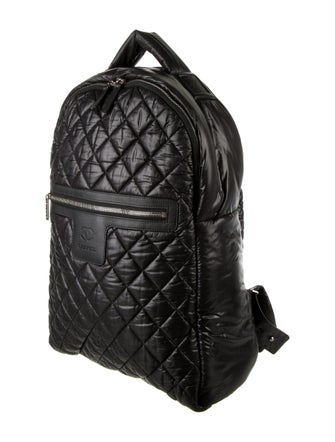

In [21]:
file_name = "./test-chanel.jpg"

# test image
from IPython.display import Image

Image(file_name)

In [22]:
endpoint_name

'sagemaker-autogluon-serving-trained-model-1659254337-384f'

In [25]:
with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(
    EndpointName="autogluon-inference-2022-07-31-08-02-06-367", ContentType="application/x-image", Body=payload
)
result = response["Body"].read()

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "loaded state dict has a different number of parameter groups
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/sagemaker_inference/transformer.py", line 110, in transform
    self.validate_and_initialize(model_dir=model_dir)
  File "/usr/local/lib/python3.7/site-packages/sagemaker_inference/transformer.py", line 158, in validate_and_initialize
    self._model = self._model_fn(model_dir)
  File "/opt/ml/model/code/vision_serve.py", line 12, in model_fn
    model = ImagePredictor.load(model_dir)
  File "/usr/local/lib/python3.7/site-packages/autogluon/vision/predictor/predictor.py", line 703, in load
    obj = pickle.load(fid)
  File "/usr/local/lib/python3.7/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", line 821, in __setstate__
    self._optimizer.load_state_dict(save_state['optimizer'])
  File "/usr/local/lib/python3.7/site-packages/torch/optim/optimizer.py", line 141, in load_state_dict
    raise ValueError("loaded state dict has a different number of "
ValueError: loaded state dict has a different number of parameter groups
". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/autogluon-inference-2022-07-31-08-02-06-367 in account 110942190652 for more information.

In [27]:
preds = predictor.predict(file_name)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "loaded state dict has a different number of parameter groups
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/sagemaker_inference/transformer.py", line 110, in transform
    self.validate_and_initialize(model_dir=model_dir)
  File "/usr/local/lib/python3.7/site-packages/sagemaker_inference/transformer.py", line 158, in validate_and_initialize
    self._model = self._model_fn(model_dir)
  File "/opt/ml/model/code/vision_serve.py", line 12, in model_fn
    model = ImagePredictor.load(model_dir)
  File "/usr/local/lib/python3.7/site-packages/autogluon/vision/predictor/predictor.py", line 703, in load
    obj = pickle.load(fid)
  File "/usr/local/lib/python3.7/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", line 821, in __setstate__
    self._optimizer.load_state_dict(save_state['optimizer'])
  File "/usr/local/lib/python3.7/site-packages/torch/optim/optimizer.py", line 141, in load_state_dict
    raise ValueError("loaded state dict has a different number of "
ValueError: loaded state dict has a different number of parameter groups
". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/autogluon-inference-2022-07-31-08-02-06-367 in account 110942190652 for more information.

In [28]:
# Clean Up
predictor.delete_endpoint()